In [155]:
import re
import datetime
from dateutil.relativedelta import relativedelta
from math import log

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns


from PyPDF2 import PdfFileWriter, PdfFileReader
from bs4 import BeautifulSoup

In [156]:


import matplotlib.pyplot as plt
from utils import news_occurance


Run on local machine

In [157]:
#local
import glob
from wikipedia import wikipedia_awards
from utils import drop_based_on_occurance

Run on eikon codebook

In [158]:
#eikon
import eikon as ek
ek.set_app_key('DEFAULT_CODE_BOOK_APP_KEY')

# POC

1. Indexing and precomputed ESG scores
2. Blacklisting
3. PanamaPapers
4. Salaries
5. Awards
    * Select international and regional awards
    * Measure the sentiment attributed to particular news.

## Year selection

In [159]:
lower_boundary_date = "2020-01-01"
upper_boundary_date = "2021-01-01"

# Indexing

In [160]:
stock_exchanges = pd.read_excel("../data/scrapped_data.xlsx", sheet_name="exchanges", usecols=[0,1])

stock_exchanges.head(2)

,MIC,Name
0,ARCX,New York Stock Exchange Archipelago
1,FMTS,MTS France SAS


In [161]:
mics = stock_exchanges["MIC"].apply(lambda x: f"'{x}'")
mics = ",".join(mics)

In [162]:
instruments = f"""SCREEN(U(IN(Equity(active,public,countryprimaryquote))),
            IN(TR.ExchangeMarketIdCode,{mics}))"""

# dates = ["2018-01-01", "2019-01-01", "2020-01-01"]
# dates = ["2020-01-01"]
dates = [lower_boundary_date]

In [163]:
columns = ['Instrument', 'Market Identifier Code (MIC)', 'Company Common Name',
       'ESG Score', 'ESG Score Grade', "date"]

ESG_data = pd.DataFrame(columns=columns)
ESG_data

,Instrument,Market Identifier Code (MIC),Company Common Name,ESG Score,ESG Score Grade,date


In [164]:
for date in dates:
    params = {'params': {"SDate": date}}
    variables = ["TR.MIC", 'TR.CommonName', {"TR.TRESGScore":params}, {"TR.TRESGScoreGrade":params}]
    data = ek.get_data(instruments=instruments, fields=variables)
    if isinstance(data, tuple):
        data = data[0]
    data["date"] = date
    ESG_data = pd.concat([ESG_data, data])

In [165]:
non_na_ESG_data = ESG_data[~ESG_data["ESG Score"].isna()]

In [166]:
non_na_ESG_data.sort_values(by="ESG Score", ascending=False)

,Instrument,Market Identifier Code (MIC),Company Common Name,ESG Score,ESG Score Grade,date
49727,SAP.N,,SAP SE,93.561930,A+,2020-01-01
8420,SAPGEUR.S,<NA>,SAP SE,93.561930,A+,2020-01-01
34738,0NW4.L,<NA>,SAP SE,93.561930,A+,2020-01-01
44964,SAPGy_p.F,,SAP SE,93.561930,A+,2020-01-01
24583,0A2W.L,,SAP SE,93.561930,A+,2020-01-01
...,...,...,...,...,...,...
6842,603019.SS,<NA>,Dawning Information Industry Co Ltd,1.039006,D-,2020-01-01
7553,300418.SZ,<NA>,Beijing Kunlun Tech Co Ltd,0.971407,D-,2020-01-01
41231,HPCO.BE,<NA>,Hallador Energy Co,0.929299,D-,2020-01-01
20052,28Y.F,<NA>,High Liner Foods Inc,0.696272,D-,2020-01-01


In [13]:
non_na_ESG_data.to_csv("../data/primary/ESG_Companies.csv", index=False)

In [14]:
ESG_data = pd.read_csv("../data/primary/ESG_Companies.csv")

In [16]:
companies_types = """(inc.?|corp.?|ag.?|ab.?|se.?|plc.?|a\.v\.v\..?|i\.l\..?|n\.v\..?|i\.l\..?|limited|ltd.?|s\.a\.|llc.?)"""

ESG_data["Company Common Name"] = ESG_data["Company Common Name"].apply(lambda x: re.sub(companies_types, "", x.lower()).strip())
ESG_data["Ticker"] = ESG_data["Instrument"].apply(lambda x:x.split(".")[0])
ESG_data = ESG_data.drop(columns="Instrument").drop_duplicates()

# Wage data

In [17]:
# load
data_russel = pd.read_excel('../data/scrapped_data.xlsx', sheet_name='PayRatiosRuss')
data_sp = pd.read_excel('../data/scrapped_data.xlsx', sheet_name='PayRatiosSP')

data_revenue_sp = pd.read_excel('../data/scrapped_data.xlsx', sheet_name="CompSP")
data_revenue_russel = pd.read_excel('../data/scrapped_data.xlsx', sheet_name="CompRussel")

data_russel.rename(columns={'Pay ratio to 1': 'PayRatio'}, inplace=True)
data_sp.rename(columns={'Pay ratio to 1': 'PayRatio'}, inplace=True)

# drop useless col
data_russel.drop(columns=['Pay RatioSort ascending'], inplace=True)
data_sp.drop(columns=['Pay RatioSort ascending'], inplace=True)

In [18]:
shape_sp, shape_russel = data_sp.shape, data_russel.shape
#
data_list = [data_russel, data_revenue_russel, data_sp, data_revenue_sp]

# compute minimum annual US salary
work_hours_annual = 2080
min_wage = 7.25
min_salary = min_wage * work_hours_annual

# create the columns with median to min ratio
data_russel['MedianMinRatio'], data_sp['MedianMinRatio'] = data_russel['MedianAnnualPay'] / min_salary, data_sp[
    'MedianAnnualPay'] / min_salary



In [19]:
# lowercase i strip na nazwach firm
data_russel['CompanyLower'] = [str.strip(str.lower(q)) for q in data_russel['Company']]
data_sp['CompanyLower'] = [str.strip(str.lower(q)) for q in data_sp['Company']]
# data_avg_salaries['CompanyLower'] = [str.strip(str.lower(q)) for q in data_avg_salaries['Company']]
data_revenue_sp['CompanyLower'] = [str.strip(str.lower(q)) for q in data_revenue_sp['Company Common Name']]

In [20]:
# lowercase i strip na nazwach firm
data_russel['CompanyLower'] = [str.strip(str.lower(q)) for q in data_russel['Company']]
data_sp['CompanyLower'] = [str.strip(str.lower(q)) for q in data_sp['Company']]
# data_avg_salaries['CompanyLower'] = [str.strip(str.lower(q)) for q in data_avg_salaries['Company']]
data_revenue_sp['CompanyLower'] = [str.strip(str.lower(q)) for q in data_revenue_sp['Company Common Name']]

# drop column
# data_avg_salaries.drop('Company', inplace=True, axis=1)
data_russel.drop('Company', inplace=True, axis=1)
data_sp.drop('Company', inplace=True, axis=1)

# cast Tickers to string and sort dataframe
for each in data_list:
    each['Ticker'] = [str(q) for q in each['Ticker']]
    each.sort_values(by='Ticker', inplace=True)


In [21]:
# merge with data from refinitiv
data_russel_no_avg = data_russel.merge(data_revenue_russel, on='Ticker')
data_sp_no_avg = data_sp.merge(data_revenue_sp, on='Ticker')

# check shapes with duplicates
shape_russel_dup = data_russel_no_avg.shape
shape_sp_dup = data_sp_no_avg.shape

# drop duplicates
data_russel_no_avg.drop_duplicates(inplace=True)
data_sp_no_avg.drop_duplicates(inplace=True)

# check shape after drop
shape_russel = data_russel_no_avg.shape
shape_sp = data_sp_no_avg.shape

#put the data into structure (albeit a trivial one)
merged_data_list = [data_russel_no_avg, data_sp_no_avg]

In [22]:
#prepare data for topsis
data_for_topsis = []

for each in merged_data_list:
    # compute efficiency wage component
    each['Comp/Reve'] = each['Labor Expenses'] / each['Revenue BA']
    # inverse pay ratio to get a stimulant
    each['PayRatioStim'] = 1 / each['PayRatio']

    # cut out the companies with 0 or negative revenues or labour expenses
    each = each.loc[(each['Revenue BA'] > 0) & (each['Labor Expenses'] > 0)]

    # prepare table for aggregation
    table_for_topsis = each[['Ticker', 'MedianAnnualPay', 'PayRatioStim', 'MedianMinRatio', 'Comp/Reve']]


    table_for_topsis.set_index('Ticker', drop=True, inplace=True)
    data_for_topsis.append(table_for_topsis)


In [23]:
scaled_data = []

for i in range(len(data_for_topsis)):

    #
    each = data_for_topsis[i]
    indeks = data_for_topsis[i].index
    columns = data_for_topsis[i].columns

    col_list = []

    for column in each.columns:

        col_to_scale = each[str(column)].values.reshape(-1, 1)
        #logarithm on the column to get rid of the outliers
        loged_col = np.array([log(q) for q in col_to_scale]).reshape(-1, 1)

        #scale by min max formula
        transformed = MinMaxScaler().fit_transform(loged_col)

        listed_transformed = transformed.reshape(1, -1).tolist()
        col_list.append(listed_transformed[0])

    #prepare scaled df
    scaled_df = pd.DataFrame(col_list).transpose()
    scaled_df.index = indeks
    scaled_df.columns = columns

    scaled_data.append(scaled_df)

#look at the data
scaled_df_rus = scaled_data[0]
scaled_df_sp = scaled_data[1]


In [24]:
rus_dist_list = []
sp_dist_list = []

#compute distances separately for russel and sp
for i in range(len(scaled_df_rus.index)):
    row = scaled_df_rus.iloc[i, :].values

    #compute euclidean distance from the best theoretical best object (since we used min max scaler the best one will be (1,1,1,1))
    dist = distance.euclidean(np.ndarray([1, 1, 1, 1]), row)
    rus_dist_list.append(dist)

for i in range(len(scaled_df_sp.index)):
    row = scaled_df_sp.iloc[i, :].values

    dist = distance.euclidean(np.ndarray([1, 1, 1, 1]), row)
    sp_dist_list.append(dist)

#prepare distance dfs
dist_df_rus = pd.DataFrame(rus_dist_list)
dist_df_sp = pd.DataFrame(sp_dist_list)

dist_df_rus.index = scaled_df_rus.index
dist_df_sp.index = scaled_df_sp.index

dist_df_rus.columns = ['Distance']
dist_df_sp.columns = ['Distance']

#put the dfs in a structure
dist_df_list = [dist_df_rus, dist_df_sp]

In [25]:
agregate_vars_df_list = []

for each in dist_df_list:
    #compute avg and std of distances
    dist_avg = np.average(each['Distance'])
    dist_std = np.std(each['Distance'])

    # compute the aggregate variable
    agregate_vars = [(1 - (q / dist_avg + (2 * dist_std))) for q in each['Distance']]

    #prepare the df
    agregate_vars_df = pd.DataFrame(agregate_vars)
    agregate_vars_df.index = each.index
    agregate_vars_df.columns = ['AggregateValue']

    agregate_vars_df_list.append(agregate_vars_df)

#prepare final dfs
final_rus = agregate_vars_df_list[0]
final_sp = agregate_vars_df_list[1]

final_rus.reset_index(inplace=True)
final_sp.reset_index(inplace=True)

#check the shapes (to see if we didnt loose anyone on our way here
final_shapes = [final_rus.copy().shape, final_sp.copy().shape]

# company_names_sp = data_russel[['Ticker', 'CompanyLower']]
# company_names_russel = data_sp[['Ticker', 'CompanyLower']]


In [26]:
wages_data = final_rus

In [27]:
# wages_data = pd.read_csv('../data/wages/fair_wage_index_russel_3000.csv')

In [28]:
ESG_data = pd.merge(ESG_data, wages_data, on="Ticker", how="inner")

ESG_data = ESG_data.rename(columns={"AggregateValue":"WagesAggregateValue"})
ESG_data

,Market Identifier Code (MIC),Company Common Name,ESG Score,ESG Score Grade,date,Ticker,WagesAggregateValue
0,NaN,finet,48.111370,NaN,2020-01-01,FN,0.162508
1,NaN,green dot,24.834505,NaN,2020-01-01,GDOT,-0.499778
2,NaN,east west ban,57.442432,B-,2020-01-01,EWBC,-0.438867
3,NaN,cvb financial,29.834081,C-,2020-01-01,CVBF,-0.457911
4,NaN,federal icultural mortg,18.077357,D+,2020-01-01,AGM,-0.646005
...,...,...,...,...,...,...,...
638,NaN,quinstreet,26.321202,C-,2020-01-01,QNST,-0.328335
639,NaN,sata technologies holding,59.879600,B,2020-01-01,ST,0.187136
640,NaN,maxlinear,23.304055,D+,2020-01-01,MXL,-0.484579
641,NaN,ss&c technologies holdings,17.853018,D+,2020-01-01,SSNC,-0.380842


# Blacklisting

### Defence companies anti corruption index

In [29]:
with open("../data/lists/csv/defence_companies_anti_corruption_index.csv", "r", encoding="unicode_escape") as f:
    file = f.readlines()

anti_corruption_data = "".join(file[5:])

with open("../data/lists/csv/defence_companies_anti_corruption_index_preprocessed.csv", "w", encoding="utf-8") as f:
    f.write(anti_corruption_data)

In [30]:
anti_corruption_data = pd.read_csv("../data/lists/csv/defence_companies_anti_corruption_index_preprocessed.csv", header=[0,1,2])

In [31]:
anti_corruption_data_filtered = anti_corruption_data[[anti_corruption_data.columns[0], anti_corruption_data.columns[-9]]].copy()
anti_corruption_data_filtered.columns = ["Company Common Name", "anti corruption score"]
anti_corruption_data_filtered["anti corruption score normalized"] = anti_corruption_data_filtered["anti corruption score"] / anti_corruption_data_filtered["anti corruption score"].max()

list_anti_corruption = anti_corruption_data_filtered[anti_corruption_data_filtered["anti corruption score normalized"]<.5]["Company Common Name"]
list_anti_corruption = list(map(lambda x: x.lower(), list_anti_corruption))

In [32]:
ESG_data = drop_based_on_occurance(ESG_data, variable="Company Common Name", condition=list_anti_corruption)
len(ESG_data)

637

### Testing on animals

In [35]:
animals_testing = PdfFileReader(open("../data/lists/pdf/companies-do-test.pdf", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: '../data/lists/pdf/companies-do-test.txt'

In [28]:
text = []
for page_idx in range(animals_testing.getNumPages()):
    text.append(animals_testing.getPage(page_idx).extractText())

In [29]:
animals_testing = "".join(text).lower()

In [30]:
ESG_data = drop_based_on_occurance(ESG_data, variable="Company Common Name", condition=animals_testing)
len(ESG_data)

930

### Fossil fuels

In [36]:
fossil_fuels = pd.read_csv("../data/lists/csv/fossil-fuels.csv")

fossil_fuels = list(fossil_fuels["Company Name"].apply(lambda x: x.lower()))

In [37]:
ESG_data = drop_based_on_occurance(ESG_data, variable="Company Common Name", condition=fossil_fuels)

In [38]:
len(ESG_data)

617

# Whitelisting

### Working for regulatory change

In [34]:
regulatory_change = PdfFileReader(open("../data/lists/pdf/companies-working-for-regulatory-change.pdf", "rb"))

In [35]:
regulatory_change_text = []
for page_idx in range(regulatory_change.getNumPages()):
    regulatory_change_text.append(regulatory_change.getPage(page_idx).extractText())

In [36]:
regulatory_change = "".join(regulatory_change_text).lower()

In [37]:
ESG_data["regulatory_change"] = ESG_data["Company Common Name"].apply(lambda x: int(x in regulatory_change))

ESG_data["regulatory_change"].sum()

0

### Cruelty free companies

In [38]:
cruelty_free = PdfFileReader(open("../data/lists/pdf/cruelty-free-companies-united-states.pdf", "rb"))

In [39]:
cruelty_free_text = []
for page_idx in range(cruelty_free.getNumPages()):
    cruelty_free_text.append(cruelty_free.getPage(page_idx).extractText())

In [40]:
cruelty_free = "".join(cruelty_free_text).lower()

In [41]:
ESG_data["cruelty_free_list"] = ESG_data["Company Common Name"].apply(lambda x: int(x in cruelty_free))

ESG_data["cruelty_free_list"].sum()

11

# Panama papers

In [39]:
files = [x for x in glob.glob("../data/paradise_papers/**", recursive=True) if "entity" in x or "intermediary" in x]

In [40]:
panama_companies = pd.DataFrame(columns=["name"], dtype=str)

In [41]:
for file in files:
    temp = pd.read_csv(file, usecols=["name"])
    panama_companies = pd.concat([panama_companies, temp])
len(panama_companies)

810869

In [42]:
panama_companies["name"] = panama_companies["name"].astype(str)

panama_companies["name"] = panama_companies["name"].apply(lambda x: re.sub(companies_types, '', x.lower()).strip())

panama_companies["name"] = panama_companies["name"].apply(lambda x: re.sub(r'\([^)]*\)', '', x.lower()).strip())

panama_companies = list(panama_companies.reset_index(drop=True)["name"])

In [43]:
ESG_data = drop_based_on_occurance(ESG_data, variable="Company Common Name", condition=panama_companies)
ESG_data = ESG_data.reset_index(drop=True)
len(ESG_data)

474

# Awards data

In [44]:
wiki_awards = wikipedia_awards()

scrapped_awards = pd.read_excel("../data/scrapped_data.xlsx", sheet_name="awards", usecols=[0,1,2])

scrapped_awards["international"] = scrapped_awards["international"].apply(lambda x: "I" in x or "R" in x)

awards = pd.concat([wiki_awards, scrapped_awards]).drop_duplicates().reset_index(drop=True)
awards["award"] = awards["award"].apply(lambda x: x.lower())

URLError: <urlopen error Tunnel connection failed: 403 Forbidden>

In [48]:
awards.to_csv("../data/awards/awards.csv", index=False)

In [45]:
awards = pd.read_csv("../data/awards/awards.csv")
awards

,international,country,award
0,True,NaN,applause award
1,True,NaN,arthur b. guise medal
2,True,NaN,golden ticket awards
3,True,NaN,hotelier of the century
4,True,NaN,seven stars luxury hospitality and lifestyle a...
...,...,...,...
659,True,NaN,topgun designation
660,True,EU,best of european business
661,True,NaN,public eye on davos
662,True,EU,100 best workplaces in europe


In [46]:
len(awards[awards["international"]==True])

466

In [47]:
ESG_data.to_csv("../data/ESG_after_awards.csv", index=False)

In [114]:
ESG_data = pd.read_csv("../data/ESG_after_awards.csv")

ESG_data = ESG_data.reset_index(drop=True)

ESG_data = ESG_data.sort_values("ESG Score", ascending=True)

In [52]:
awards = pd.read_csv("../data/awards/awards.csv")
awards

,international,country,award
0,True,NaN,applause award
1,True,NaN,arthur b. guise medal
2,True,NaN,golden ticket awards
3,True,NaN,hotelier of the century
4,True,NaN,seven stars luxury hospitality and lifestyle a...
...,...,...,...
659,True,NaN,topgun designation
660,True,EU,best of european business
661,True,NaN,public eye on davos
662,True,EU,100 best workplaces in europe


### Sample companies based on ESG score distribution

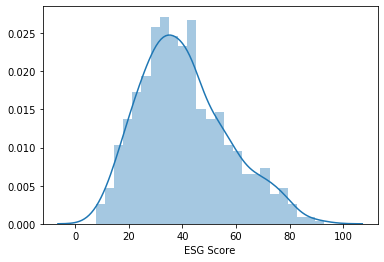

In [53]:
sns.distplot(ESG_data["ESG Score"], bins=25)
plt.show()


In [59]:
ESG_sample_data = ESG_data.sample(100)
ESG_sample_data.to_csv("../data/ESG_sample.csv")

ESG_sample_data = pd.read_csv("../data/ESG_sample.csv")
ESG_sample_data.head(1)

,Unnamed: 0,Market Identifier Code (MIC),Company Common Name,ESG Score,ESG Score Grade,date,Ticker,WagesAggregateValue,Unnamed: 0.1
0,0,NaN,insulet,60.411802,B,2021-01-01,PODD,-0.462837,NaN


In [60]:
awards["award"] = awards["award"].apply(lambda x: x.lower().strip())

international_awards = list(awards[awards["international"]==True]["award"])
regional_awards = list(awards[awards["international"]==False]["award"])

In [61]:
news_info = []

In [37]:
%%time
for idx, ticker in enumerate(ESG_sample_data["Ticker"]):
    try:
        ticker_occurance = news_occurance(ticker=ticker, regional_awards=regional_awards, international_awards=international_awards,
                                  date_to="2020-01-01", date_from="2020-12-31")
        news_info.append(ticker_occurance)
    except:
        time.sleep(10)
        print(f"Ticker {idx} failed")
    

Starting idx 0
Starting idx 1
2020-12-31
2020-10-16
2020-08-11
2020-06-24
2020-05-11
2020-03-11
Starting idx 2
Starting idx 3
Starting idx 4
Starting idx 5
Starting idx 6
Starting idx 7
Starting idx 8
2020-12-31
2020-10-21
2020-08-24
2020-07-09
2020-05-11
2020-03-31
Starting idx 9
Starting idx 10
2020-12-31
2020-11-23
2020-10-14
2020-09-08
2020-08-06
2020-07-01
2020-05-27
2020-04-23
2020-03-19
Starting idx 11
Starting idx 12
2020-12-31
2020-11-11
2020-09-18
2020-07-15
2020-05-13
Ticker 12 failed
Starting idx 13
Starting idx 14
Starting idx 15
2020-12-31
2020-07-30
2020-04-30
2020-02-20
Starting idx 16
Starting idx 17
2020-12-31
2020-11-30
2020-10-27
2020-09-26
2020-08-24
2020-07-22
2020-06-18
2020-05-18
2020-04-22
2020-03-27
2020-03-02
Starting idx 18
Starting idx 19
Starting idx 20
Starting idx 21
Starting idx 22
Starting idx 23
Starting idx 24
Starting idx 25
Starting idx 26
2020-12-31
2020-09-09
2020-06-05
2020-03-19
Starting idx 27
Starting idx 28
2020-12-31
2020-09-08
2020-06-10
2

In [38]:
news_info = pd.DataFrame(news_info)

In [75]:
news_info.sort_values("international_occurance", ascending=False)

,Ticker,regional_occurance,international_occurance
3,FAF,False,True
16,LUV,False,True
23,TRS,False,False
21,PPBI,False,False
20,MDRX,False,False
...,...,...,...
30,BEN,False,False
29,CASS,False,False
28,BCOR,False,False
27,MITK,False,False


As only two companies from sample we're rewarded, we will ommit this variable in further index calculations. Although, having possibility to search directly in the news text not only Refinitiv headlines it can be assumed that awards variable shouldn't be given upon yet.

# Index

In [167]:
#data load
# data = ESG_data
data = pd.read_csv("../data/ESG_after_awards.csv")

In [168]:
#print(data.head(10))
# make the Wage index positive
data['WagesAggregateValue'] = data['WagesAggregateValue'] + 5

from sklearn.preprocessing import MinMaxScaler

transformed_cols = []
data_to_transform = data[['ESG Score','WagesAggregateValue']]


#scaling
for column in data_to_transform:

    col_to_scale = data_to_transform[str(column)].values.reshape(-1, 1)

    transformed = MinMaxScaler().fit_transform(col_to_scale)

    listed_transformed = transformed.reshape(1, -1).tolist()
    transformed_cols.append(listed_transformed[0])

transformed_data = pd.DataFrame(transformed_cols,index= ['ESG Score','WagesScore']).transpose()


#print(transformed_data.head(10))

transformed_data[['Ticker','Company Common Name']] = data[['Ticker','Company Common Name']]

transformed_data['T_Index'] = np.zeros(len(transformed_data.index))

for i in range(len(transformed_data.index)):
    a = transformed_data.loc[i, 'ESG Score']
    b = transformed_data.loc[i, 'WagesScore']

    avg = (a+b)/2

    transformed_data.loc[i, 'T_Index'] = avg

# print(transformed_data.head(10))

#sorted df with our final T index score
final_df = transformed_data.sort_values('T_Index',ascending=False)

#top 20 companies which will be our portfolio
portfolio_df = final_df[:20]

In [82]:
portfolio_df.to_csv("../data/portfolio.csv")

# Portfolio vs Russel 3000 performance

## Timeseries retrieval

In [173]:
ESG_tickers = pd.read_csv("../data/primary/ESG_Companies.csv")

In [174]:
companies_types = """(inc.?|corp.?|ag.?|ab.?|se.?|plc.?|a\.v\.v\..?|i\.l\..?|n\.v\..?|i\.l\..?|limited|ltd.?|s\.a\.|llc.?)"""

ESG_tickers["Company Common Name"] = ESG_tickers["Company Common Name"].apply(lambda x: re.sub(companies_types, "", x.lower()).strip())
ESG_tickers["Ticker"] = ESG_tickers["Instrument"].apply(lambda x:x.split(".")[0])

In [175]:
portfolio_merged = pd.merge(portfolio_df[["Company Common Name", "T_Index"]], ESG_tickers, on="Company Common Name", how="inner")

In [181]:
portfolio_merged

,Company Common Name,T_Index,Instrument,Market Identifier Code (MIC),ESG Score,ESG Score Grade,date,Ticker
0,hannon armstrong sustaine infrastructure capital,0.811916,HASI.N,NaN,78.768249,A-,2021-01-01,HASI
1,hannon armstrong sustaine infrastructure capital,0.811916,6HA.F,NaN,78.768249,A-,2021-01-01,6HA
2,hannon armstrong sustaine infrastructure capital,0.811916,0J2Z.L,NaN,78.768249,A-,2021-01-01,0J2Z
3,host hotels & resorts,0.797503,0J66.L,NaN,88.957802,A,2021-01-01,0J66
4,host hotels & resorts,0.797503,HMTa.F,NaN,88.957802,A,2021-01-01,HMTa
...,...,...,...,...,...,...,...,...
68,regency centers,0.683683,REG.F,NaN,77.542536,A-,2021-01-01,REG
69,regency centers,0.683683,REG.OQ,NaN,77.542536,A-,2021-01-01,REG
70,telenet group holding nv,0.675825,0GAF.L,NaN,76.693844,A-,2021-01-01,0GAF
71,telenet group holding nv,0.675825,TNET.BE,NaN,76.693844,A-,2021-01-01,TNET


In [182]:
instruments = list(portfolio_merged["Instrument"])

In [183]:
timeseries_portfolio = ek.get_timeseries(instruments,
                 start_date="05-13-2016", 
                  end_date=datetime.timedelta(0), 
                  interval='daily')

In [184]:
timeseries_portfolio.columns = timeseries_portfolio.columns.map("_".join)

In [185]:
selection = [x for x in timeseries_portfolio.columns if "CLOSE" in x]

In [186]:
timeseries_portfolio = timeseries_portfolio[selection]

In [187]:
timeseries_portfolio.to_csv("../data/portfolio_timeseries.csv")

In [188]:
timeseries_portfolio

,HASI.N_CLOSE,6HA.F_CLOSE,0J2Z.L_CLOSE,0J66.L_CLOSE,HMTa.F_CLOSE,HST.OQ_CLOSE,SHO_pe.N_CLOSE,SHO_pf.N_CLOSE,SHO.F_CLOSE,SHO.N_CLOSE,CIM.AX_CLOSE,LTHG.F_CLOSE,COF_pg.N_CLOSE,0HT4.L_CLOSE,COF_pl.N_CLOSE,COF_pk.N_CLOSE,COF_pi.N_CLOSE,COF_ph.N_CLOSE,COF_pj.N_CLOSE,COF.N_CLOSE,0HD2.L_CLOSE,ALNY.OQ_CLOSE,ALNY.F_CLOSE,OC.F_CLOSE,OC.N_CLOSE,HBANO.OQ_CLOSE,0J72.L_CLOSE,HBANP.OQ_CLOSE,HBANN.OQ_CLOSE,HBAN.OQ_CLOSE,DRH_pa.N_CLOSE,DRH.F_CLOSE,DRH.N_CLOSE,HT_pc.N_CLOSE,HT_pd.N_CLOSE,HT_pe.N_CLOSE,H3U1.F_CLOSE,HT.N_CLOSE,LPLA.OQ_CLOSE,7LI.BE_CLOSE,NLOK.OQ_CLOSE,SYM1.F_CLOSE,JPM_pg.N_CLOSE,JPM_ph.N_CLOSE,CMC1.F_CLOSE,JPMUSD.S_CLOSE,0Q1F.L_CLOSE,JPM_pk.N_CLOSE,JPM_pj.N_CLOSE,JPM_pc.N_CLOSE,JPM_pd.N_CLOSE,JPM.F_CLOSE,JPM.N_CLOSE,AMJ.P_CLOSE,0L8F.L_CLOSE,LUV.F_CLOSE,LUV.N_CLOSE,WHG.N_CLOSE,BVE.F_CLOSE,DHIL.OQ_CLOSE,PNC_pp.N_CLOSE,0KEF.L_CLOSE,PNC.BE_CLOSE,PNC.N_CLOSE,GILDUSD.S_CLOSE,0QYQ.L_CLOSE,GILD.OQ_CLOSE,0KUT.L_CLOSE,REG.F_CLOSE,REG.OQ_CLOSE,0GAF.L_CLOSE,TNET.BE_CLOSE,TNET.BR_CLOSE
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,66.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07,47.99,39.50,NaN,NaN,14.050,17.58,25.70,NaN,10.40,12.74,18.93,12.200,25.7900,NaN,24.69,25.8700,26.48,26.00,25.8001,157.71,<NA>,131.30,108.85,85.5,106.92,25.40,NaN,25.50,25.95,15.80,28.94,8.15,10.11,24.2250,23.72,23.6100,9.25,11.63,156.00,129,21.095,17.180,25.00,25.00,103.39,NaN,159.5,26.07,26.47,27.8700,27.2900,131.46,161.24,18.50,NaN,49.815,61.66,19.81,146.0,178.43,26.37,NaN,164.45,198.91,NaN,66.598,66.54,NaN,53.5,65.36,34.07651,34.02,34.06
2021-05-10,48.32,39.28,NaN,NaN,14.356,17.11,25.40,NaN,10.10,12.24,19.32,12.392,25.7501,NaN,24.55,25.8357,26.40,25.90,25.7300,157.38,<NA>,128.63,107.60,89.5,108.22,25.38,NaN,25.42,25.91,15.76,28.75,8.00,9.76,24.2500,23.59,23.4999,9.00,10.91,152.26,128,21.080,17.266,24.99,24.99,NaN,NaN,163.5,26.00,26.38,27.8400,27.2500,134.24,161.22,18.75,NaN,51.130,61.35,20.15,147.0,176.00,26.31,NaN,164.05,198.56,NaN,68.165,67.48,NaN,54.0,65.43,34.02510,34.12,34.02
2021-05-11,47.47,39.02,NaN,NaN,13.954,16.99,25.27,NaN,9.90,12.19,19.06,12.222,25.6600,154.135,24.35,25.7400,26.33,25.82,25.5000,154.76,<NA>,132.41,104.95,85.0,105.59,25.39,15.775,25.27,25.66,15.66,28.50,7.